In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import pysam
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import csv

In [2]:
homo = []
for i in range(1,96):
    file = pd.read_csv(f'../als_cfdna_samples/ucsf/g_broutput/{i}.bracken', delimiter='\t')
    value = file.loc[file['name'] == 'Homo', 'new_est_reads'].values[0]
    homo.append(value)
homo.append(0)
for i in range(97,193):
    file = pd.read_csv(f'../als_cfdna_samples/uq/g_broutput/{i-96}.bracken', delimiter='\t')
    value = file.loc[file['name'] == 'Homo', 'new_est_reads'].values[0]
    homo.append(value)

In [4]:
test = pd.read_csv(f'../als_cfdna_samples/ucsf/kroutput/1.report.txt', delimiter='\t', header=None)

In [5]:
test.columns = ['percent', 'num_rooted', 'num_covered', 'rank', 'taxid', 'name']

In [6]:
test['name'] = test['name'].str.lstrip()

In [7]:
test.head()

,percent,num_rooted,num_covered,rank,taxid,name
0,6.21,7369,7369,U,0,unclassified
1,93.79,111232,0,R,1,root
2,93.79,111232,766,R1,131567,cellular organisms
3,90.30,107097,0,D,2759,Eukaryota
4,90.30,107097,0,D1,33154,Opisthokonta


In [8]:
test.loc[test['name'] == 'unclassified', 'num_rooted'].values[0] #unclassified

7369

In [9]:
test.loc[test['name'] == 'root', 'num_rooted'].values[0] #root (all classified reads)

111232

In [10]:
test.loc[test['name'] == 'Homo sapiens', 'num_rooted'].values[0] #reads assigned to homo sapiens

107097

In [56]:
thresh = 10

In [19]:
for i in range(1,97):
    file = pd.read_csv(f'../als_cfdna_samples/ucsf/g_broutput_threshold_{thresh}/{i}.bracken', delimiter='\t')
    file[file['name'] != 'Homo'].to_csv(f'../als_cfdna_samples/ucsf/g_broutput_filtered_{thresh}/{i}.bracken', sep='\t', index=False)
    
for i in range(97,193):
    file = pd.read_csv(f'../als_cfdna_samples/uq/g_broutput_threshold_{thresh}/{i-96}.bracken', delimiter='\t')
    file[file['name'] != 'Homo'].to_csv(f'../als_cfdna_samples/uq/g_broutput_filtered_{thresh}/{i-96}.bracken', sep='\t', index=False)

In [57]:
#get all genera present in all samples
genera = []
for i in range(1,96):
    file = pd.read_csv(f'../als_cfdna_samples/ucsf/g_broutput_filtered_{thresh}/{i}.bracken', delimiter='\t')
    for genus in file['name']:
        genera.append(genus)
for i in range(1,97):
    file = pd.read_csv(f'../als_cfdna_samples/uq/g_broutput_filtered_{thresh}/{i}.bracken', delimiter='\t')
    for genus in file['name']:
        genera.append(genus)

In [58]:
len(genera)

8509

In [59]:
uniq_genera = list(set(genera))

In [60]:
len(uniq_genera)

341

In [61]:
genera_counts = pd.DataFrame(0, index=np.arange(192), columns=uniq_genera)
genera_counts.insert(0, 'sample_num', np.arange(1, 193))

In [62]:
genera_present = genera_counts.copy()

In [63]:
genera_present

,sample_num,Thiothrix,Stigmatella,Haliangium,Marinobacterium,Aromatoleum,Changpingibacter,Sulfuricella,Solitalea,Polaribacter,...,Caulobacter,Teredinibacter,Rheinheimera,Phreatobacter,Algoriphagus,Sphingobacterium,Olsenella,Salmonella,Lactococcus,Bacillus
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,188,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188,189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189,190,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190,191,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
for i in range(1,97):
    file = pd.read_csv(f'../als_cfdna_samples/ucsf/g_broutput_filtered_{thresh}/{i}.bracken', delimiter='\t')
    for genus in uniq_genera:
        if genus in file['name'].values:
            genera_present.at[i-1, genus] = 1
            genera_counts.at[i-1, genus] = file.loc[file['name'] == genus, 'new_est_reads'].values[0]
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


In [65]:
for i in range(97,193):
    file = pd.read_csv(f'../als_cfdna_samples/uq/g_broutput_filtered_{thresh}/{i-96}.bracken', delimiter='\t')
    for genus in uniq_genera:
        if genus in file['name'].values:
            genera_present.at[i-1, genus] = 1
            genera_counts.at[i-1, genus] = file.loc[file['name'] == genus, 'new_est_reads'].values[0]
    print(i)

97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192


In [66]:
genera_present.to_csv(f"../als_cfdna_samples/genera_present_binary_{thresh}.csv", index=None)

In [67]:
genera_counts.to_csv(f"../als_cfdna_samples/genera_counts_{thresh}.csv", index=None)

In [69]:
genera_present = pd.read_csv("../als_cfdna_samples/genera_present_binary_5.csv")
genera_counts = pd.read_csv("../als_cfdna_samples/genera_counts_5.csv")

In [70]:
genera_counts.head()

,sample_num,Tetragenococcus,Bdellovibrio,Metabacillus,Roseimaritima,Alysiella,Segatella,Thiothrix,Phascolarctobacterium,Tatumella,...,Nannocystis,Salmonella,Kurthia,Izhakiella,Lactococcus,Marinilactibacillus,Bacillus,Aurantiacibacter,Nakamurella,Marivirga
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,12,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,26,0,0,0,0,27,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,24,0,0,0,0,43,0,0,0


In [4]:
ucsf_dissimilarity_matrix = pd.read_csv('../als_cfdna_samples/ucsf/diversity/beta.csv', index_col=0)
uq_dissimilarity_matrix = pd.read_csv('../als_cfdna_samples/uq/diversity/beta.csv', index_col=0)

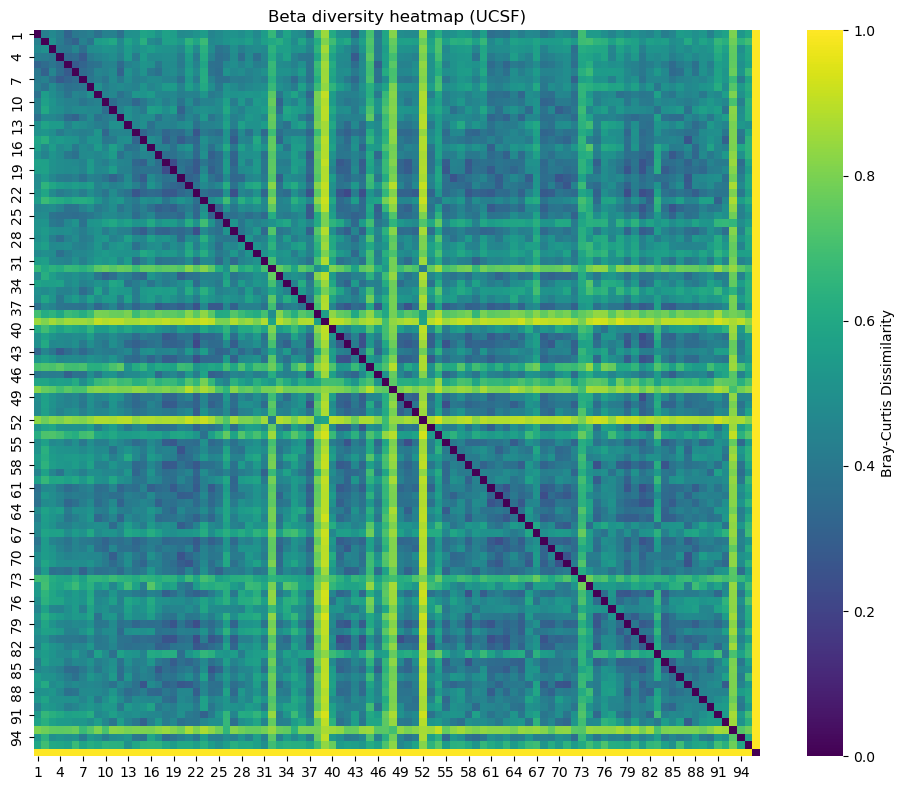

In [5]:
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(ucsf_dissimilarity_matrix, cmap='viridis', annot=False, fmt=".3f",
            cbar_kws={'label': 'Bray-Curtis Dissimilarity'}, square=True)

plt.title('Beta diversity heatmap (UCSF)')

# Step 4: Show the heatmap
plt.tight_layout()
plt.show()

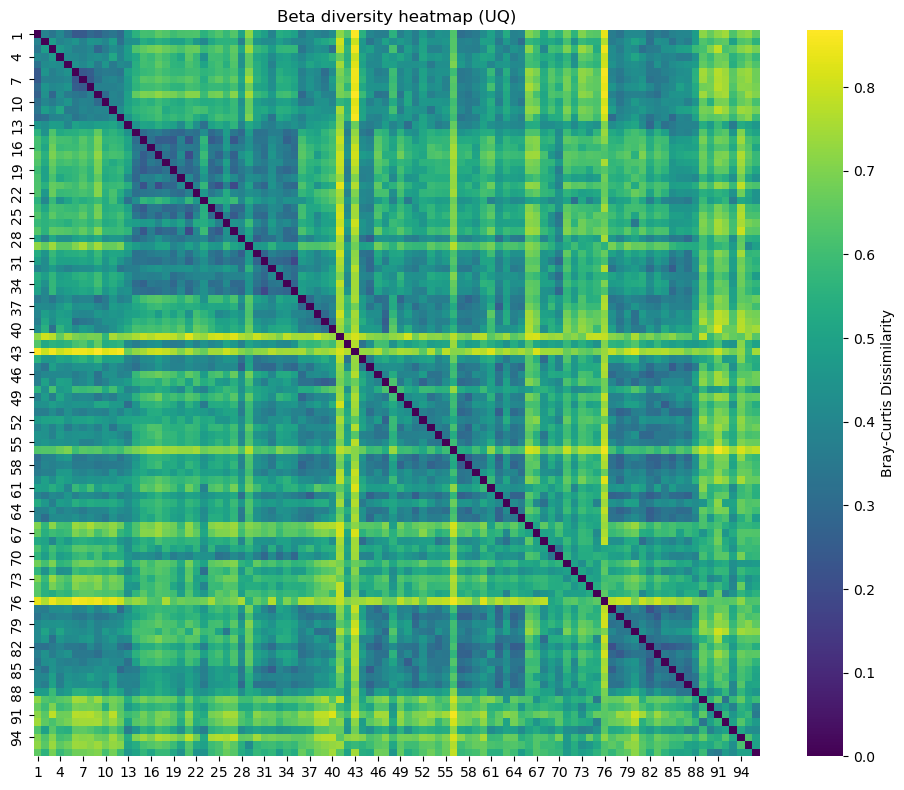

In [6]:
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(uq_dissimilarity_matrix, cmap='viridis', annot=False, fmt=".3f",
            cbar_kws={'label': 'Bray-Curtis Dissimilarity'}, square=True)

plt.title('Beta diversity heatmap (UQ)')

# Step 4: Show the heatmap
plt.tight_layout()
plt.show()

In [12]:
clinical = pd.read_csv("../als_cfdna_samples/combined_metadata_redone.csv")
ucsf_clinical = clinical[clinical['cohort'] == 'ucsf']
uq_clinical = clinical[clinical['cohort'] == 'uq']

In [14]:
ucsf_sorted = ucsf_clinical.sort_values(by='sample_type')
uq_sorted = uq_clinical.sort_values(by='sample_type')

In [28]:
ucsf_dissimilarity_matrix.index = ucsf_dissimilarity_matrix.index.astype(str)
ucsf_dissimilarity_matrix.columns = ucsf_dissimilarity_matrix.columns.astype(str)

uq_dissimilarity_matrix.index = uq_dissimilarity_matrix.index.astype(str)
uq_dissimilarity_matrix.columns = uq_dissimilarity_matrix.columns.astype(str)

In [30]:
ucsf_sorted_samples = ucsf_sorted['sample_num'].astype(str).tolist()
ucsf_sorted_dissimilarity_matrix = ucsf_dissimilarity_matrix.loc[ucsf_sorted_samples, ucsf_sorted_samples]

#uq_sorted_samples = uq_sorted['sample_num'].astype(str).tolist()
#uq_sorted_dissimilarity_matrix = uq_dissimilarity_matrix.loc[uq_sorted_samples, uq_sorted_samples]

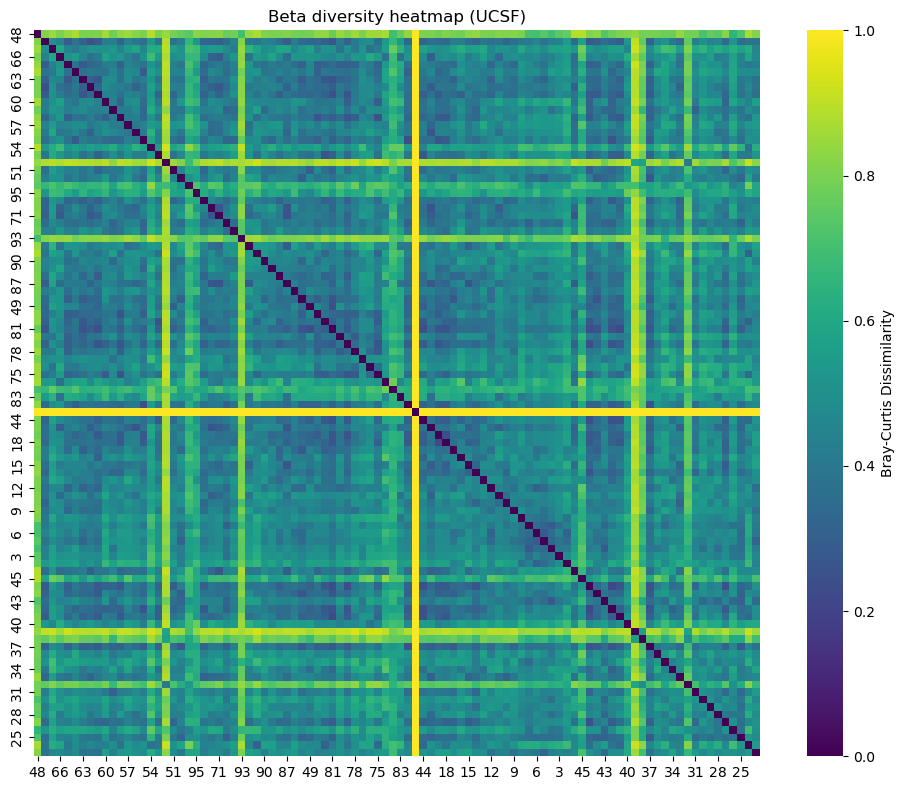

In [32]:
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(ucsf_sorted_dissimilarity_matrix, cmap='viridis', annot=False, fmt=".3f",
            cbar_kws={'label': 'Bray-Curtis Dissimilarity'}, square=True)

plt.title('Beta diversity heatmap (UCSF)')

# Step 4: Show the heatmap
plt.tight_layout()
plt.show()